In [1]:
# validationf VeRITAS
# we validate how well veritas is doing when we cannot ask too many question
# Typically, we want to evaluate performance in conjunction with a CAT framework
# Conclusion: It seems CAT's question generation is not abest for Veritas
# we can ask similar number of questions, but get much better performance if we 
# generate the questiosn differently, namely questions that not only 
# take into account the goal of getting to diagnosis, but also detection of malingering

In [2]:
import sys
import pandas as pd
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()
import pylab as plt
from sklearn import metrics
from zedstat import zedstat


In [3]:
# it seems R20 gets pretty high AUC and performs better than CAT
# we cannot test that with 713, because we onbly have cat results
# but teh deployment uses R20 (may tre rand)
# plots:
# i. kappa distr, ;; nu distr;; mu distr for model pos mpde neg
# do teh same for 304 dataset  (can estimate false positive)
# do it for deploy data set (failures are false negatives)
# it seems 304 dataset has only 3-7 malingerers, which is 7/86 or 1/12 or 8.3%

In [4]:
# resf is generated using calc_parallel_res.py

In [29]:
C0=.9
C1=0.76
C2=.94
def malinger(row):
    if (row.lower_threshold < C0) and (row.score > C2):
        return -1
    if (row.veritas > C1) and (row.score > C2):
        return -1    
    if (row.score < C2):
        return 0
    else:
        return 1

In [30]:
resf=pd.read_csv('../res_R20_model1.csv',index_col=0).T
resf=pd.read_csv('../res_R20_model3.csv',index_col=0).T
resf=pd.read_csv('../res_R20_model2.csv',index_col=0).T
#resf=pd.read_csv('../res_exp_model2.csv',index_col=0).T
#resf=pd.read_csv('../res_R20_model8.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
DX=True
if DX:
    resf['dx'] = [int(x[-1]) for x in resf.index.values]
else:
    resf['dx'] = [x>C2 for x in resf.score.values]


In [31]:
resf['mg']=resf.apply(malinger,axis=1)

In [34]:
if DX:
    fpr, tpr, thresholds = metrics.roc_curve(resf.dx.values.astype(int),resf.score.values.astype(float), pos_label=1)
    ff=pd.DataFrame(tpr,fpr,columns=['tpr']).assign(threshold=thresholds)
    ff.index.name='fpr'
    zt=zedstat.processRoc(df=ff.reset_index(),
                          order=3, 
                          total_samples=304,
                          positive_samples=86,
                          alpha=0.01,
                          prevalence=0.5)
    zt.smooth(STEP=0.001)
    zt.allmeasures(interpolate=True)
    zt.usample(precision=3)
    Z=zt.get()
    print(Z[Z.ppv>.81].tail(10))

            tpr       ppv       acc       npv       LR+       LR-  threshold
fpr                                                                         
0.221  0.793323  0.814299  0.786200  0.795289  3.810180  0.260598   0.953452
0.222  0.794542  0.813830  0.786310  0.795983  3.794874  0.259444   0.951856
0.223  0.795761  0.813360  0.786420  0.796678  3.779567  0.258291   0.950260
0.224  0.796980  0.812891  0.786530  0.797373  3.764260  0.257137   0.948664
0.225  0.798200  0.812422  0.786640  0.798068  3.748953  0.255983   0.947068
0.226  0.799419  0.811952  0.786751  0.798763  3.733646  0.254830   0.945472
0.227  0.800638  0.811483  0.786861  0.799457  3.718340  0.253676   0.943876
0.228  0.801857  0.811014  0.786971  0.800152  3.703033  0.252522   0.942280
0.229  0.803076  0.810544  0.787081  0.800847  3.687726  0.251368   0.940684
0.230  0.804295  0.810075  0.787191  0.801542  3.672419  0.250215   0.939088


m-ratio:  0.1744186046511628
full:  (0.8742732558139535, 0.9302263389753077, 0.8183702236034638)


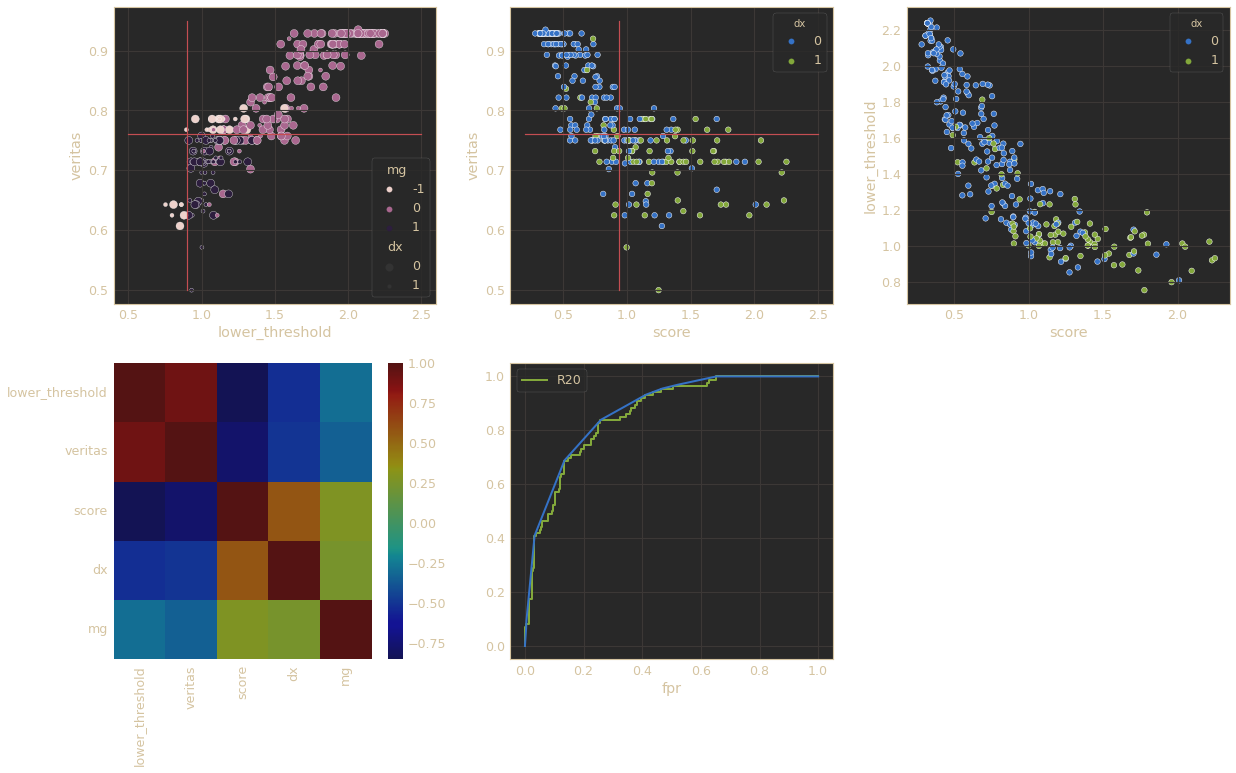

In [33]:
plt.figure(figsize=[20,12])
plt.subplot(231)
sns.scatterplot(data=resf,x='lower_threshold',y='veritas',hue='mg',size='dx')
plt.plot([.5,2.5],[.76,.76],'-r')
plt.plot([C0,C0],[.5,.95],'-r')

plt.subplot(232)
ax=sns.scatterplot(data=resf,x='score',y='veritas',hue='dx')
plt.plot([.2,2.5],[C1,C1],'-r')
plt.plot([C2,C2],[.5,.95],'-r')

plt.subplot(233)
sns.scatterplot(data=resf,x='score',y='lower_threshold',hue='dx')
plt.subplots_adjust(wspace=0.23)  # Adjust this value as needed

cf=resf.corr()
plt.subplot(234)
sns.heatmap(cf,cmap='jet',alpha=.5)
print('m-ratio: ',(resf[(resf.mg==-1) & (resf.dx==1)].index.size)/86)


plt.subplot(235)

plt.plot(fpr,tpr,'g',lw=2)
plt.gca().legend(['R20'])
zt.get().tpr.plot(style='-b',lw=2)
print('full: ',zt.auc())

In [10]:
resf

,lower_threshold,veritas,score,dx,mg
CAT10050,1.766693,0.901883,0.680022,0,0
CAT10010,0.928472,0.714286,1.248364,0,0
CAT10020,1.117376,0.785714,1.025116,0,0
CAT10030,1.308874,0.767857,1.061628,0,0
CAT10040,1.775565,0.892857,0.684865,0,0
...,...,...,...,...,...
CAT12990,1.286232,0.767857,0.606269,0,0
CAT13011,1.133075,0.720779,1.325811,1,0
CAT13020,1.523528,0.793067,0.720745,0,0
CAT13040,1.895962,0.910714,0.444272,0,0


In [11]:
resf[(resf.mg==-1)].index.size

40

In [12]:
resf

,lower_threshold,veritas,score,dx,mg
CAT10050,1.766693,0.901883,0.680022,0,0
CAT10010,0.928472,0.714286,1.248364,0,0
CAT10020,1.117376,0.785714,1.025116,0,0
CAT10030,1.308874,0.767857,1.061628,0,0
CAT10040,1.775565,0.892857,0.684865,0,0
...,...,...,...,...,...
CAT12990,1.286232,0.767857,0.606269,0,0
CAT13011,1.133075,0.720779,1.325811,1,0
CAT13020,1.523528,0.793067,0.720745,0,0
CAT13040,1.895962,0.910714,0.444272,0,0
